In [1]:
%matplotlib inline

import sys, os
_utils_dir = os.path.join(os.path.abspath('.'), 'utils')
if _utils_dir not in sys.path:
    sys.path.insert(0, _utils_dir)

There are many hard things to grasp in quantum mechanics:

- the algebra of commutators
- Hamiltonians & Lagrangians
- Hilbert-Space
- Sturm-Liouville theory
- the inexplicable profusion of complex numbers, etc.

One of these things is the 'quantum mode'.

We're told that such modes live in an infinite-dimensional space, and that in order to identify them analytically we need to solve large differential equations, changing variables more frequently than influencers change clothes.

The end result is that you never quite feel like you're talking about something concrete, something that you could possibly state rigorous conclusions for.

Fortunately, with a relatively simple splash of matrix algebra we can show what's really going on.

...which is what I'll be attempting here.


<aside class="nb-primary-reference" >This post follows along with part of chapter 11 of Brunton & Kutz's wonderful book <cite id="cite_databookuw"><a href="http://www.databookuw.com/">Data-Driven Science and Engineering</a> [1]</cite>:<figure align="center"><img src="assets/ddsae_cover.jpeg" max-width="150"><figcaption>Cover of 'Data-Driven Science and Engineering'</figcaption></figure></aside>


## A quick review of Singular Value Decomposition (SVD)

Matrices, in essence, encode a translation between two worlds - the column-world (M) and the row-world (N). 

<figure align="center" class="nb-diagram"><img src="assets/matrices.png" max-width="400"><figcaption>Figure 1: Multiple visual representations of matrices. Source: TeaochaDesign</figcaption></figure>

When we first learn about matrices we tend to think of them as highly numerical constructs. But that needn't be the case.

As shown in Figure 1, a matrix could also represent something such as language translation, in which the values in the cells of the matrix represent how much two linguistic concepts in two different languages are related.

Likewise, also illustrated, we can think of a video as a sequence of spatial snapshots - with columns being moments in time, and rows being points in space. As you move left-to-right you follow the change in energy of a single point across the topology of time, conversely as you move top-to-bottom you follow the topology of space at a single moment in time. (This is the picture we'll be using in this post).

The problem though, is that our brains don't really think in terms of atoms and pixels. If I describe to you how a bird flaps its wings I'm going to describe it using a sequence of large-scale shapes, rather than tell you how each atom moves. If you and I agree on a set of shapes, then the gazillions of atoms that compose each shape is implied.

<figure align="center" class="nb-diagram"><img src="assets/modes_v_pixels.png" max-width="250"><figcaption>Figure 2: Illustration of a low-rank-mode view vs pixels. Source: TeaochaDesign</figcaption></figure>

The formal way of saying this is that I tell you about the matrix in terms of **low-rank modes**. Here **modes** refers to the degrees of freedom containing the information (i.e. the shapes), and **rank** refers to the amount of them.

The pixels themselves are of course 'modes' too (modes are just another word for 'basis') but they're a high-rank basis - you've taken the information and you've spread it incredibly thinly across a huge number of participants.

So how do we take some data expressed in terms of pixel modes, and turn it into the most efficient 'shape' modes?

Answer: We can use the **Singular-Value-Decomposition (SVD)**

At its heart, the SVD is really just a generalised eigen-decomposition. When we perform an eigen-decomposition we take a square matrix and we 'rotate' the rows and columns until we've found a basis in which the matrix is diagonal - i.e. a basis in which columns are orthogonal/independant/decoupled. We can then put the columns in order of eigenvalue magnitude (max to min) which will give us a set of importance-ordered modes.

However this isn't possible for general matrices, like the ones we'll be using, because general matrices aren't necessarily square, i.e. they don't map a space to itself, they map *between* spaces.

To fix this we instead diagonalize the [Gram Matrix](https://en.wikipedia.org/wiki/Gram_matrix) - effectively the square of the matrix:

\begin{equation}
X^TX
\tag{1}
\label{eq:1}
\end{equation}

The Gram Matrix is diagonalisable by virtue of being square and symmetric  and, once diagonalised, we have a basis in which variation is separated into orthogonal degrees of freedom. <cite id="cite_symmetric">(Liesen & Mehrmann, 2015, pp. 203-207)</cite> [2]

This is our SVD basis.

Given that our matrix $X$ is actually $n \times m$ (i.e. not square) the basis which diagonalises the Gram Matrix actually admits two perspectives, which we call $U$ (for the $n$ world) and $V$ (for the $m$ world). We write that

\begin{equation}
X = U \Sigma V^*
\tag{2}
\label{eq:2}
\end{equation}

where $\Sigma$ is the diagonal matrix of size-ordered eigenvalues. Depicted as follows:

<figure align="center" class="nb-diagram"><img src="assets/svd.png" max-width="400"><figcaption>Figure 3: Depiction of the Compact-SVD. Source: TeaochaDesign</figcaption></figure>

In this image (figure 3) you can see that $\Sigma$ has size $r \times r$. Here, $r$ is the rank of the matrix or, in other words, the number of non-zero degrees of freedom. (However, depending on the implementation, you may be given a full $n \times m$ matrix which includes all of the zero eigenvalues.)

This magical decomposition allows us to take something like a movie (perhaps of that bird flapping its wings) and decompose it into a set of orthogonal still images (the $n$ world, of wing shapes) and corresponding time snapshots (the $m$ world, of shape transitions).

The ordered eigenvalues will then tell us which shapes/motions give the the simplest description of the video; that is, the highest $s << r$ modes will give us a **low-rank** representation.

This is precisely what we'll use to find the most important modes of the quantum simple-harmonic-oscillator.

## The Plan

In order to explore the power of the SVD we're going to do the following:

1. Write down a dynamic equation, that is, an equation of the form

    \begin{equation}
    \frac{dA}{dt} = f(A)
    \tag{3}
    \label{eq:3}
    \end{equation}
    
2. Step an initial condition $A_0$ forward in time by pluggin (3) into an integrator, and take a digestable number of evenly spaced snapshots out of the result.
3. Run the SVD on the snapshots of step 2 and plot the highest-rank modes.
4. Compare our results to what we would obtain analytically.

So, with that plan, let's begin.

### 1. The Dynamical Equation

One of the most well known equations of quantum mechanics is the Schrödinger equation, which takes the following form (assuming $\hbar=1,m=1$):

\begin{equation}
i\frac{d}{dt}\Psi(x,t)=[-\frac{1}{2}\frac{d}{dx^2}+V(x)]\Psi(x,t)
\tag{4}
\label{eq:4}
\end{equation}

If you look closely though (by which I mean divide both sides by $i$), you'll notice that this is nothing more than an equation for a dynamical system. So this is what we'll be using the step our system forward. We'll define an initial distribution, and a potential, and then run the right-hand-side recursively until we hit a stopping condition of our choosing.

However, to make things simpler for ourselves, we'll first do a little bit of equation munging.

In accordance with the premise of this post, we assume that we can express the system as a sum of some static spatial modes - static poses - which at a given instant of time are each weighted by a value indicating how much of that pose is present in the overall signal. Over time, it is the weights alone that vary, not the poses. So, for example, in a unitary basis $\phi_k$, we could write

\begin{equation}
\Psi(x,t) = \sum_{k=0}^\infty\phi(x)_kw(t)_k
\tag{5}
\label{eq:5}
\end{equation}

If our dynamical system is linear, with the form

\begin{equation}
\frac{d\Psi(x,t)}{dt}=F(x, t)[\Psi(x,t)]
\tag{6}
\label{eq:6}
\end{equation}

then inserting (5) into (6) gives an equation for the evolution of the $k_{th}$ weight like so

\begin{equation}
\frac{dw_k(t)}{dt}=[\phi^{\dagger}_k(x)F(x, t)\phi_k(x)]w_k(t)=F_{\phi_k}(t)w_k(t)
\tag{7}
\label{eq:7}
\end{equation}

that is, rotating into such a basis gives us a much simpler equation. The term $F_{\phi_k}(t)$ is just the rotated dynamics; rotated into a world where things evolve according to a single variable - time.

The Schrödinger equation allows us to do just that. We can write

\begin{equation}
\frac{dw_k(t)}{dt}=\phi^{\dagger}_k(x)\frac{1}{i}[-\frac{1}{2}\frac{d}{dx^2}+V(x)]\phi_k(x)w_k(t)
\tag{8}
\label{eq:8}
\end{equation}

There are many unitary bases we can pick to do this (the goal of this post is to find the most information-efficient one). One such basis is the Fourier basis, in which the equation becomes

\begin{equation}
\frac{dw_k(t)}{dt}=\frac{1}{i}[-\frac{1}{2}(ik)^2w_k(t)+V_k]
\tag{9}
\label{eq:9}
\end{equation}

which is much simpler (the second-derivatives have just become squares). So that's what we'll use. We'll run an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) on our variables before running the simulation, and then convert them back afterwards.

### 2. The Simulation

For this post we'll be studying the simple-harmonic-oscillator:

\begin{equation}
V(X) = \frac{1}{2}X^2
\tag{10}
\label{eq:10}
\end{equation}

and we'll start the system off with an initial distribution of

\begin{equation}
\Psi_0(X)=e^{-\frac{1}{5}(X-1)^2}
\tag{11}
\label{eq:11}
\end{equation}

which represents a gaussian bump just off center (to make sure that we induce some anti-symmetric modes).

Let's get to it...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45

# Personal utils to remove cognitive clutter.
# (See 'https://github.com/teaochablog/svg-quantum-dynamics/utils')
import blogutils
blogutils.init_mpl(plt)

In [3]:
# Define global variables relating to the simulation space

L = 30           # The width of the quantum well
N = 512          # The number of spatial divisions
X = np.linspace(-L/2, L/2, N)
K = ((2*np.pi/L)*np.concatenate([
    np.arange(0, N/2),
    np.arange(-N/2, 0)
    ]))          # The fourier frequencies

# Variables for stepping the simulation forward
T_STEP = 0.25
T_MAX = 10
T_0 = 0.0
N_STEPS = T_MAX/T_STEP

# Initial Conditions
PSI_0 = np.exp(-0.2*(X-1)**2)
A_0 = np.fft.fft(PSI_0)
V_SHO = 0.5*X**2

In [4]:
# Create the right-hand-side of the integrator

def make_fourier_schrodinger_stepper(k_vec, v_x_vec):
    '''
    Returns a RHS stepper for an ode solver of the potential-well
    Schrodinger equation.
    
    :param k_vec   An array of fourier frequencies
    :param v_x_vec An array of the spatial potential
    '''
    def _stepper(_t, _a_k_vec):
        # Compute the potential interaction in the spatial basis
        # and then map back to the frequency basis
        _psi_x_vec = np.fft.ifft(_a_k_vec)
        _v_k_vec = np.fft.fft(v_x_vec*_psi_x_vec)
        
        # Then return the step in the fourier basis
        _d_a_k_vec = -1j*(0.5*(k_vec**2)*_a_k_vec + _v_k_vec)
        return _d_a_k_vec
    return _stepper

Now, with everything set up, we are ready to run the simulation. We'll be using a [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) integrator to step the Fourier modes forward.

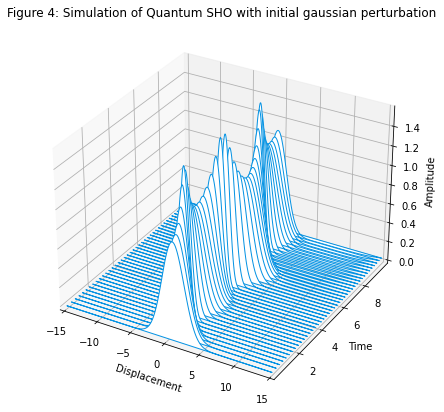

In [5]:
# Runge-Kutta-45 solver
sho_stepper = make_fourier_schrodinger_stepper(K, V_SHO)
sho_solution = RK45(sho_stepper, T_0, A_0, T_MAX, max_step=T_STEP)

sho_t, sho_a = blogutils.make_integrator_snapshots(sho_solution, N_STEPS)
sho_psi = np.array([np.abs(np.fft.ifft(a)) for a in sho_a])

# Plot the resulting wavefunction
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=[18, 7])
ax.set_title('Figure 4: Simulation of Quantum SHO with initial gaussian perturbation')
ax.set_xlabel('Displacement')
ax.set_ylabel('Time')
ax.set_zlabel('Amplitude')
blogutils.plot_waterfall(X, sho_t, sho_psi, ax)

Looking good. We can see that as time passes the amplitude of the quantum wave swings back and forth across the origin, as we would expect from a harmonic oscillator.

However, what we've ended up with looks complex.

Let's see whether the SVD agrees with that assessment.

### 3. Run the SVD

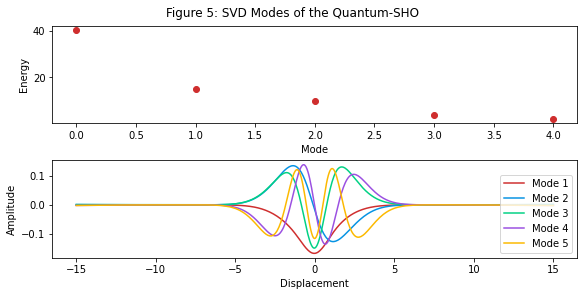

In [6]:
svd_t, svd_energies, svd_modes = np.linalg.svd(sho_psi, full_matrices=False)

N_MODES = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8, 4], constrained_layout=True)
fig.suptitle('Figure 5: SVD Modes of the Quantum-SHO')

ax1.scatter(np.arange(N_MODES), svd_energies[:N_MODES])
ax1.set_xlabel('Mode')
ax1.set_ylabel('Energy')

for m in range(N_MODES):
    ax2.plot(X, svd_modes[m], label=f'Mode {m + 1}')
ax2.legend(loc='lower right')
ax2.set_xlabel('Displacement')
ax2.set_ylabel('Amplitude');

As you can see, most of the energy of the system is concentrated within 3-4 SVD modes.

We can reaffirm this by reconstructing the wave, including increasing numbers of modes each time:

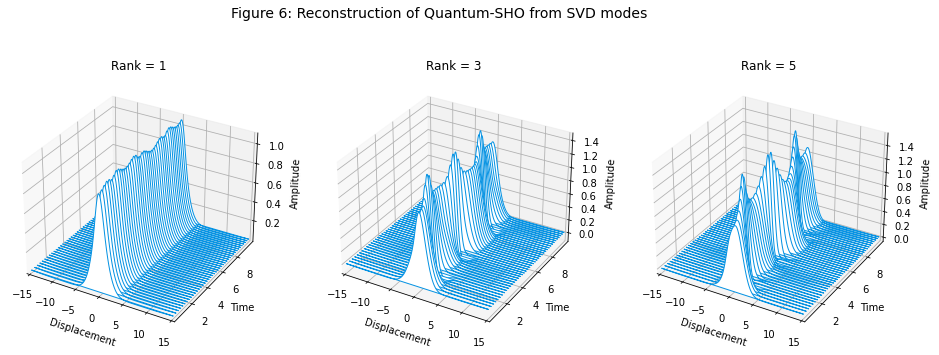

In [7]:
MODE_RECONSTRUCTIONS = [1, 3, 5]

fig, axes = plt.subplots(1, len(MODE_RECONSTRUCTIONS), subplot_kw={"projection": "3d"}, figsize=[16, 8])
fig.suptitle('Figure 6: Reconstruction of Quantum-SHO from SVD modes', y=0.85, fontsize=14)
for i, m in enumerate(MODE_RECONSTRUCTIONS):
    reconstruction = blogutils.inverse_svd(svd_t, svd_energies, svd_modes, m)
    ax = axes[i]
    ax.set_title(f'Rank = {m}')
    ax.set_xlabel('Displacement')
    ax.set_ylabel('Time')
    ax.set_zlabel('Amplitude')
    blogutils.plot_waterfall(X, sho_t, reconstruction, ax)

After five modes the result is barely distinguishable from the full-rank version.

That is, we've managed to reconstruct the dynamics of the system with about five 'shapes'. In the same way that an animator might create the illusion of a character jogging by cycling between five or so poses, we're able to describe a seemingly complex quantum-mechanical system using five 'poses' of a quantum well.

But how well does this compare to the classical view?

### 4. Comparison with analytic methods

Classically, to solve this problem, physicists would make use of analytic tools such as [Sturm-Liouville theory](https://en.wikipedia.org/wiki/Sturm%E2%80%93Liouville_theory) - a method for solving second-order ODEs (i.e. equations describing dynamical systems of a single independant variable).

Applying Sturm-Liouville to the harmonic oscillator we find that <cite id="cite_hermite">(Brunton & Kutz, 2019, p. 450)</cite> [3] the solutions are the Gauss-Hermite polynomials:

\begin{equation}
\Psi_k(x)=(-1)^{k}e^{-\frac{1}{2}x^2}\frac{d^2}{dx^2}e^{-\frac{1}{2}x^2}
\tag{12}
\label{eq:12}
\end{equation}

which we can then plot:

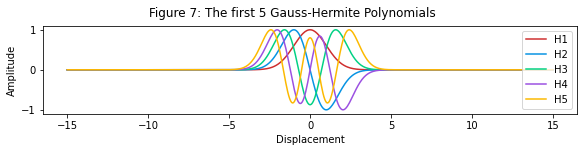

In [8]:
from scipy.special import hermite

N_POLYS = 5
fig, ax = plt.subplots(figsize=[8, 2], constrained_layout=True)
fig.suptitle(f'Figure 7: The first {N_POLYS} Gauss-Hermite Polynomials')

for p in range(N_POLYS):
    HY = np.power(-1, p)*\
        np.exp(-0.5*X**2)*\
        hermite(p, monic=True)(X)
    HY = HY / np.abs(np.max(HY)) # Scale all to have height 1 - like our modes
    ax.plot(X, HY, label=f'H{p + 1}')
ax.legend(loc='lower right')
ax.set_xlabel('Displacement')
ax.set_ylabel('Amplitude');

Some of the modes detected by the SVD (Figure 5) have opposite sign to those here, however it is clear the the shapes of the modes are the same. This implies that we've managed to find the correct structure of the solution, without having to memorise a textbook on differential equations.

Very promising.

## Concluding thoughts

There *are* some caveats to using the SVD for these purposes, such as:

- You lose the mathematical insight telling you which geometric concepts fused together to form the solution.
- You can only extract what is there in the data (e.g. if you don't take enough snapshots, or if you don't excite certain modes with your boundary conditions, you won't see that information in the output modes).

However, it's worth questioning how important such caveats are in the modern era of computation. Where should we draw the line between using analytical methods vs computational methods?

We often talk about machine-learning as 'black-box' methods, which produce 'uninterpretable' models, however is Sturm-Liouville really that much more interpretable? Does it really give us a deeper geometric insight into what's going on, or is it just another plug-and-play tool for getting results?

What I think is great about this example, and advances in data-science in general, is that they nudge us to re-evaluate classical methods like these. Classical analytic tools tend to have value lying half in the realm of interpretability and half in the realm of 'getting the job done'. But that latter value is rapidly waning. We have faster tools now.

However that doesn't mean these tools are valueless. It means that they get to reposition their value as pure tools of interpretation, rather than trying to straddle two objectives.

What is the special-sauce in these tools that makes them interpretable? That's the question we're gaining the freedom to answer.

## Bibliography

- 1,3: Brunton, S. L., & Kutz, J. N. (2019). Data-driven science and engineering: machine learning, dynamical systems, and control. Cambridge University Press. https://doi.org/10.1017/9781108380690
- 2: Liesen, J., & Mehrmann, V. (2015). Linear Algebra. Springer International Publishing. https://doi.org/10.1007/978-3-319-24346-7




## Links

<a class="github-link" href="https://github.com/teaochablog/svd-quantum-dynamics">View this notebook on GitHub</a>